In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import skimage.color as color

from torch.utils.data import DataLoader
from torchvision import transforms as tf, datasets as ds
from torchvision.utils import make_grid


In [2]:
data_root_color = 'C:/DataSets/Celeba/sample'
data_root_grayscale = 'C:/DataSets/Celeba/grayscale'
workers = 2
batch_size = 128
image_size = 256
nc = 3  # Number of output color channels.
nz = 1  # Number of input color channels (Latent vector).
ngf = 64    # Depth of feature map, carried through the generator(G).
ndf = 64    # Depth of feature map, carried through the discriminator(D).

number_epochs = 5
lr = 2e-4
beta = 5e-1
ngpu = 1
weight_decay = 1e-1

In [3]:
is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda_available and ngpu > 0 else 'cpu')
device

device(type='cuda', index=0)

In [4]:
image_transform = {
    "rgb": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    "gray": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5], std=[0.5])
    ])
}

In [5]:
# Grayscale image dataset load.
gray_set = ds.ImageFolder(root=data_root_grayscale, transform=image_transform["gray"])

In [6]:
gray_loader = DataLoader(gray_set, batch_size, shuffle=True, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'GRAYSCALE IMAGE SAMPLE')

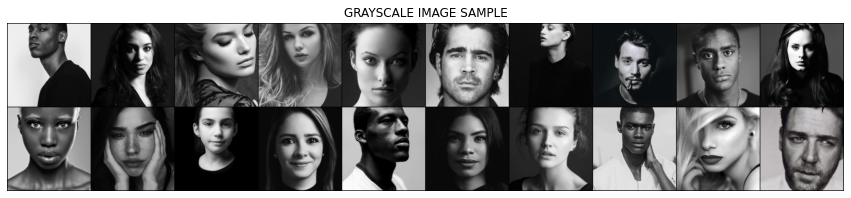

In [7]:
g_im = next(iter(gray_loader))

g_grid = make_grid(g_im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(g_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('GRAYSCALE IMAGE SAMPLE')

In [8]:
color_set = ds.ImageFolder(root=data_root_color, transform=image_transform["rgb"])

In [9]:
color_loader = DataLoader(color_set, batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'COLOR IMAGE SAMPLE')

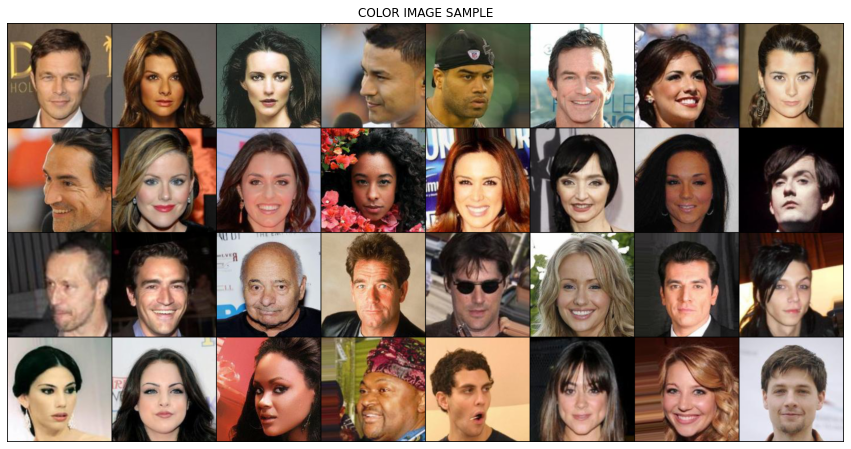

In [10]:
c_im = next(iter(color_loader))

c_grid = make_grid(c_im[0][32:64], nrow=8, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(c_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('COLOR IMAGE SAMPLE')

In [11]:
def lab2rgb(image, dim):
    """
    :param image is a single Lab image the shape of (X, y, 3)
    :param dim to define the color-channel dimension.
    """
    image = np.transpose(image, axes=(1, 2, 0))

    z = np.zeros_like(image)
    if dim != 0:
        z[:, :, 0] = 80 # Increase the brightness to show other color channels(a & b).

    z[:, :, dim] = image[:, :, dim]
    return color.lab2rgb(z)


In [12]:
class RGB2LAB(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))


class RGB2L(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted to LAB and extract L channel.
        :return: the L color channel image.
        """
        return color.rgb2lab(np.array(image))[:, :, 0]

In [13]:
image_transform['lab'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2LAB(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_transform['l'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2L(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5], std=[0.5])
])

In [17]:
lab_set = ds.ImageFolder(root=data_root_color, transform=image_transform['lab'])
lab_loader = DataLoader(lab_set, batch_size, num_workers=0, pin_memory=is_cuda_available)

l_set = ds.ImageFolder(root=data_root_color, transform=image_transform['l'])
l_loader = DataLoader(l_set, batch_size, num_workers=0, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'B CHANNEL SAMPLE')

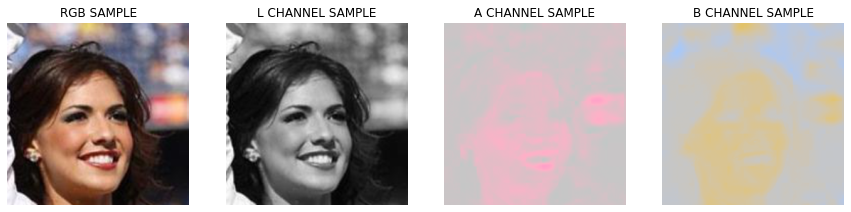

In [15]:
IMG_INDEX = 38

lab_im = next(iter(lab_loader))[0][IMG_INDEX]

plt.figure(figsize=(15, 14))

plt.subplot(141)
plt.imshow(np.transpose(c_im[0][IMG_INDEX], axes=(1, 2, 0)))
plt.axis('off')
plt.title('RGB SAMPLE')

plt.subplot(142)
plt.imshow(lab2rgb(lab_im, 0))
plt.axis('off')
plt.title('L CHANNEL SAMPLE')

plt.subplot(143)
plt.imshow(lab2rgb(lab_im, 1))
plt.axis('off')
plt.title('A CHANNEL SAMPLE')

plt.subplot(144)
plt.imshow(lab2rgb(lab_im, 2))
plt.axis('off')
plt.title('B CHANNEL SAMPLE')

TypeError: Invalid shape (256, 256, 1) for image data

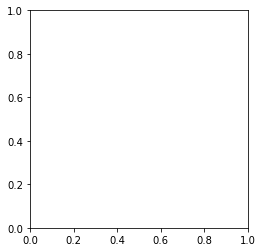

In [19]:
l_im = next(iter(l_loader))[0][IMG_INDEX]

plt.imshow(np.transpose(l_im, axes=(1, 2, 0)))